<a href="https://colab.research.google.com/github/pachterlab/GP_2021_2/blob/main/gg211030_fltseq_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Validation of path graph bursty CME solutions using long-read scRNA-seq data

In this notebook, we validate theoretical constraints on intra-gene transcript-transcript correlations using a [FLT-seq](https://www.biorxiv.org/content/10.1101/2020.08.10.243543v1) dataset. Essentially, FLT-seq, combined with the FLAMES pipeline, can identify novel, potentially intermediate transcripts, and quantify them. However, three challenges arise: no robust pipeline to infer splicing graphs on a genome-wide scale is available; even if one were, computing the likelihoods is far too computationally intensive; finally, it is unrealistic to suppose that no technical noise is present in the sequencing process.

Nevertheless, we can still approach a simpler version of the problem. The marginal transcript distributions imply nontrivial upper bounds on the transcript-transcript correlations. We can identify "source" transcripts that cannot be reached from any other transcript, perform a simple negative binomial fit, and test whether the correlation structure accords with the theoretical limit.

## Prerequisites

Install packages for gene database structure, interval tree analysis, and `gff` parsing.

In [ ]:
%%capture
!pip install mygene
!pip install intervaltree
!pip install gffutils

In [ ]:
import numpy as np
import pandas as pd
import mygene
import statsmodels
from statsmodels import discrete
from statsmodels.discrete import discrete_model
import scipy
from scipy import stats

from intervaltree import Interval, IntervalTree
import networkx as nx
import gffutils
import matplotlib.pyplot as plt
from textwrap import wrap
import time 
from scipy.stats import nbinom
# from scipy.stats import bootstrap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!curl -o fit_nbinom.py https://raw.githubusercontent.com/gennadygorin/fit_nbinom/master/fit_nbinom.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3032  100  3032    0     0  18155      0 --:--:-- --:--:-- --:--:-- 18155


In [ ]:
from fit_nbinom import fit_nbinom

In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
#a e s t h e t i c s
col_gold = [203/255,197/255,149/255]
col_gray = [116/255,112/255,113/255]
col_red = [212/255,107/255,75/255]

fig_font_size = 18
fig_lw = 4

Collect processed data from the [FLT-seq GitHub repository](https://github.com/LuyiTian/FLTseq_data).

In [ ]:
%%capture
!curl  -o PromethION_MuSC.zip -L https://github.com/LuyiTian/FLTseq_data/blob/master/data/PromethION_MuSC.zip?raw=true
!unzip PromethION_MuSC.zip
!cp PromethION_MSC/FLTSA_output/transcript_count.csv.gz .
!gunzip transcript_count.csv.gz
!cp PromethION_MSC/cluster_annotation.csv .

Import the transcript count data into a `pandas` dataframe and filter cells by cluster. `cluster1` contains quiescent cells, per Fig. S1B of the FLT-seq manuscript.

In [ ]:
bc = pd.read_csv('cluster_annotation.csv')
bc_q_filt = bc['groups']=='cluster1'
bc_q = list(bc[bc_q_filt]['barcode_seq'])
bc_a = list(bc[~bc_q_filt]['barcode_seq'])
df = pd.read_csv('transcript_count.csv')

Inspect the dataframe. There are roughly 90,000 transcripts, many of them novel.

In [ ]:
df

,transcript_id,gene_id,AAACGGGCAACGATGG,GAATAAGCATCGATGT,TGAGCCGGTAGGGTAC,TGACTTTCAGCTGGCT,ACTGTCCTCATATCGG,TACGGATTCGTACCGG,TTAGGACGTATAGGTA,GCGACCAGTCGAGTTT,GAACGGAGTCATATCG,GGACAGACACAGCCCA,AGTGTCAAGGCTCATT,TTGAACGTCAACACGT,ACTATCTTCTACCTGC,CGATGTACACCATGTA,CGGACTGCAAGAAGAG,TGCCAAACATCCGCGA,AACTCTTGTCACCTAA,CCAGCGACACGGTAAG,CTCGGGACATCACAAC,CAGCTGGCACTACAGT,GGGCACTCAGCTCCGA,GGCCGATAGGCGCTCT,GTTCGGGGTCTGCAAT,TTGTAGGTCAGTGTTG,CGATGGCTCGGGAGTA,GCTGCTTTCGGTCTAA,GGTGCGTGTTACGTCA,CATCAGACATTGGGCC,CTGTGCTTCCGATATG,ATCTACTAGGAATGGA,ATCATGGGTGACGGTA,TTGTAGGTCGGACAAG,TAGCCGGTCCTGTACC,GACCAATCAGTTCCCT,GCCTCTACAGCTGGCT,ACTGAACGTCGGGTCT,TTTGTCATCACGGTTA,TAGTTGGGTTCAACCA,...,ACTTACTCAGATAATG,ACGCCGACATCACGTA,TAGTTGGAGGACAGCT,GTGTGCGCATTGTGCA,GAATAAGGTAACGTTC,ACTGTCCTCAAGGTAA,GTAGTCAAGTTTGCGT,CCGTACTAGTAGGCCA,CAGCGACCAAGTCATC,GCGACCACATGCAACT,CCAGCGAGTATCACCA,TTAGTTCTCTACCAGA,CTAGAGTTCCAAGCCG,GACTGCGTCATAACCG,GATCTAGAGGACAGAA,GCGAGAAAGAGCTTCT,AGCGGTCGTTATCACG,ACTGAACAGCTGAACG,TCAACGAAGTAGATGT,CTGATCCCACGACTCG,CATGGCGAGGTGTGGT,AGGTCATAGCGTGAAC,AGAATAGAGCCAGTAG,TTGGCAAAGGGTTTCT,AGCGGTCAGGCTCATT,CTCATTATCGAGGTAG,TTCGGTCTCTCGTTTA,TCGCGAGCACAGATTC,ATTATCCGTCAGGACA,TGGTTCCAGGTGTGGT,ATGGGAGCAATGCCAT,AGCGGTCGTTCCAACA,GCAATCACAAACGCGA,GGGCACTTCCTAAGTG,ATCACGAGTCTCTTAT,ATCTACTCAGACAAAT,CAGAGAGAGGGTCTCC,CATATTCCACTAGTAC,CACCTTGAGATATGCA,TCACAAGAGCGTCAAG
0,ENSMUSG00000029270.10_107909202_107987033_1,ENSMUSG00000029270.10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ENSMUSG00000031951.8_111912011_111915338_1,ENSMUSG00000031951.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ENSMUSG00000021365.15_41311357_41359000_1,ENSMUSG00000021365.15,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ENSMUSG00000058388.14_103991104_104007488_1,ENSMUSG00000058388.14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ENSMUSG00000041236.8_18791585_18866811_1,ENSMUSG00000041236.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89169,ENSMUSG00000022407.10_80948504_80969119_2,ENSMUSG00000022407.10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89170,ENSMUSG00000022407.10_80948504_80969119_5,ENSMUSG00000022407.10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89171,ENSMUSG00000022407.10_80948504_80969119_4,ENSMUSG00000022407.10,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,12,0,0,0,1,6,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,3,0,0,1,0,0,0,0,2,1,0,5,0,0,0,0,0,2,0,0,0,0
89172,ENSMUSG00000034667.8_121611476_121626358_1,ENSMUSG00000034667.8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Oddly, there are 1 cell in quiescent and 43 cells in active annotations that do not seem to be represented in the transcript count matrix.

In [ ]:
print(len([k for k in df.columns[2:] if k in bc_a]))
print(len(bc_a))

137
190


In [ ]:
print(len([k for k in df.columns[2:] if k in bc_q]))
print(len(bc_q))

51
52


For convenience, we take the gene IDs and convert them to gene names.

In [ ]:
mg = mygene.MyGeneInfo()

Query them using `mygene`...

In [ ]:
gene_names = mg.querymany(list(set([k.split('.')[0] for k in df.gene_id])), scopes='ensembl.gene', fields='symbol', species='mouse')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-13557...done.
Finished.
99 input query terms found no hit:
	['ENSMUSG00000095087', 'ENSMUSG00000095142', 'ENSMUSG00000064494', 'ENSMUSG00000099316', 'ENSMUSG000
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [ ]:
len(gene_names)

13557

In [ ]:
gn = [g for g in gene_names if 'symbol' in g]

In [ ]:
len(gn)

13454

103 gene IDs are not in the annotations. We discard them.

In [ ]:
gn = {g['query']: g['symbol'] for g in gn}

In [ ]:
namecol = [gn.get(g.split('.')[0]) for g in df.gene_id]

In [ ]:
df.insert(2,'gene_name',namecol)

In [ ]:
filt = [True if namecol[i] is not None else False for i in range(len(namecol))]

We filter out the transcripts that correspond to undefined gene IDs -- this comes out to 28 rows.

In [ ]:
df = df[filt]

Construct separate dataframes for active and quescent clusters.

In [ ]:
df_a = df.filter(items=['transcript_id','gene_id','gene_name']+bc_a,axis=1)

In [ ]:
df_q = df.filter(items=['transcript_id','gene_id','gene_name']+bc_q,axis=1)

Let's look at gene-level data and identify the 500 genes with highest expression (computed as sum of all transcripts across all cells).

In [ ]:
n_high_exp_genes = 500

In [ ]:
df_a_gene = df_a.groupby(['gene_name']).sum()

In [ ]:
df_a_gene.sum(1).sort_values(ascending=False)[:n_high_exp_genes]

gene_name
Tmsb10    81345
Rplp0     78882
Lgals1    73201
Rps2      71498
Eef1a1    69491
          ...  
Psmc3      2224
Ak6        2222
Snx5       2221
Arpc4      2212
Phlda1     2207
Length: 500, dtype: int64

In [ ]:
high_exp_genes = df_a_gene.sum(1).sort_values(ascending=False)[:n_high_exp_genes].index

In [ ]:
filt = [True if df_a_gene.index[i] in high_exp_genes else False for i in range(len(df_a_gene.index))]

In [ ]:
df_a_gene = df_a_gene[filt]

In [ ]:
df_a_gene

,ATTTCTGCAAGCTGAG,TTGTAGGTCAGTGTTG,TGGCGCAGTACGCACC,TCAGGATTCACCCGAG,ACCGTAACAAGCGTAG,TGGACGCAGAACTGTA,TGGTTCCAGGTGTGGT,TCGTACCTCCTTGCCA,AAGCCGCGTGTGAATA,CCTCAGTCATCGACGC,CAAGAAACATATACCG,GACTAACTCCAAAGTC,GATCGCGCATCCCACT,GAACGGAGTCGCATCG,GGTGCGTAGAACAACT,CAGCTGGGTGCCTGGT,GACACGCGTATCTGCA,GTGTGCGCATTGTGCA,CCTTACGTCACGCATA,TCTCTAACAATGAAAC,CTGTGCTTCCGATATG,GATGAGGAGAACAACT,CGGACTGCAAGAAGAG,ATCCGAATCTGGCGAC,CAAGGCCCAAGCGTAG,CTCGTACGTACTTGAC,GTACGTATCTTCATGT,GAGTCCGCATTGGTAC,CGCCAAGCATCCGCGA,CGTGAGCCACATTCGA,GTAACTGAGATGAGAG,GGATGTTAGGTTACCT,TCGCGAGGTCTAGAGG,CGGACTGAGTTGAGTA,CTAATGGGTCGCATCG,GCACATAAGCAGACTG,CTTGGCTCATTGAGCT,ACTGAACCACAACGCC,TGGACGCAGAAGATTC,GTCGTAATCCTTGCCA,...,CGATGTACACCATGTA,TCTGGAAGTATAGGGC,ACAGCCGTCTTGAGAC,AGCGGTCGTTCCAACA,CCGTACTCAATCGGTT,CCGTACTAGTAGGCCA,CGGACACGTCTCAACA,ACGTCAAGTATGCTTG,TCAGGATAGTACCGGA,TGATTTCCACGGTAAG,GGACAGACACAGCCCA,CCAATCCAGTCATGCT,ATCATCTTCCGTAGGC,CACCACTCAGTAGAGC,CACCTTGTCTGCAGTA,AGCGGTCGTTATCACG,ACACCGGAGGAGTACC,AGCGTATTCTATCCTA,GCGAGAAAGAGCTTCT,GACGTGCTCGTCGTTC,TTATGCTCACGTCAGC,TCAGGATAGAAGGTTT,TGATTTCAGATGTGTA,GGGTTGCAGATGCCAG,AGAATAGAGGAGTACC,GGGCACTTCTGTTGAG,TTAGGACGTATAGGTA,CGGAGTCCACAGGAGT,CTGATCCCAGATTGCT,CTCGGGACATCACAAC,TCTATTGGTGATGATA,TCACAAGAGTTTAGGA,CAGCATAAGACGACGT,CATCGAACACATGACT,CGTCTACAGAGTGAGA,TGCCCTACACCCAGTG,TAGTTGGGTTCAACCA,TAGGCATGTCTCCATC,ACTGATGTCCAACCAA,GTAGGCCTCTCGCATC
gene_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Actb,148,215,154,328,73,135,110,57,64,110,280,238,66,81,80,36,118,158,70,134,121,309,98,63,84,96,388,39,61,332,23,122,336,52,165,60,130,98,146,40,...,26,12,3,15,8,56,7,2,19,3,8,2,1,8,65,24,0,2,2,2,8,6,6,3,0,5,3,14,3,5,8,0,2,11,2,1,8,9,1,1
Actg1,648,866,1243,1812,566,870,1189,433,1125,706,1368,1508,861,545,850,578,1047,595,526,742,1261,1479,770,395,399,256,749,378,620,1288,271,695,1109,869,806,930,1291,568,1117,438,...,88,87,48,56,24,116,28,5,67,56,43,13,34,53,233,104,44,9,26,9,33,29,32,16,15,6,5,47,21,19,47,20,2,52,15,3,34,24,7,6
Actr3,67,70,68,46,41,42,76,37,51,66,20,50,37,21,48,13,25,42,47,74,59,34,62,25,44,35,79,18,33,59,36,25,40,31,43,55,37,51,47,10,...,1,0,0,4,0,19,0,0,2,0,0,0,0,2,34,6,1,0,0,0,0,3,4,2,0,1,1,8,1,0,2,0,3,2,0,1,3,2,0,0
Adrm1,46,49,23,54,37,69,24,26,66,53,55,57,43,29,17,21,20,75,76,30,32,53,65,28,19,17,45,17,30,51,26,53,84,29,71,42,31,67,105,15,...,1,9,0,5,0,15,0,0,4,2,7,1,0,1,11,5,2,4,0,0,0,1,0,0,0,1,1,8,2,0,2,0,0,0,1,3,2,0,0,1
Ahcy,15,103,57,30,40,74,41,15,51,27,58,74,44,23,58,19,59,16,19,36,118,55,24,20,30,23,67,12,49,23,19,76,16,51,41,28,40,24,52,34,...,0,3,1,4,0,18,5,0,2,0,3,0,0,3,28,11,4,0,0,0,1,0,2,2,0,0,1,6,1,0,3,1,0,1,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ybx1,201,166,121,161,237,232,188,148,241,202,91,129,182,224,102,88,141,172,74,158,118,94,109,141,142,100,168,53,129,86,104,94,109,160,122,139,71,140,177,127,...,4,16,5,13,5,21,6,1,14,7,2,6,6,9,45,15,3,0,4,3,2,0,6,3,0,1,4,15,3,1,8,1,1,7,1,1,7,2,0,0
Ywhae,127,226,144,279,123,154,212,82,134,73,171,213,98,134,39,47,60,114,54,139,127,125,109,78,83,80,162,53,106,105,71,184,96,130,116,63,76,79,131,39,...,3,28,20,22,14,28,0,4,14,8,6,4,1,6,57,26,3,1,1,0,3,10,4,1,4,1,0,25,4,0,6,1,2,4,5,3,5,0,1,0
Ywhah,73,93,61,47,47,63,53,32,89,20,54,59,23,68,0,8,50,19,41,50,26,43,32,38,70,32,71,11,28,58,18,65,27,40,35,21,53,64,19,5,...,1,1,8,2,0,2,0,1,1,1,0,0,5,1,17,4,2,0,1,2,0,3,2,1,0,0,1,2,0,0,1,1,1,2,1,3,3,1,0,0


## Submolecular data processing

Now, consider the submolecular features identified using FLAMES. We care about the annotated isoform file, which can be processed by `gffutils`. 

In [ ]:
!head -10 PromethION_MSC/FLTSA_output/isoform_annotated.filtered.gff3

##gff-version 3
chr7	FLTSA	gene	3289179	3313348	.	+	.	ID=gene:ENSMUSG00000068566.12;gene_id=ENSMUSG00000068566.12;support_count=824
chr7	FLTSA	transcript	3290705	3302995	.	+	.	ID=transcript:ENSMUSG00000068566.12_3290705_3302995_1;transcript_id=ENSMUSG00000068566.12_3290705_3302995_1;Parent=gene:ENSMUSG00000068566.12;support_count=12
chr7	FLTSA	exon	3290705	3290792	.	+	.	exon_id=exon:3290705_3290792;Parent=transcript:ENSMUSG00000068566.12_3290705_3302995_1;rank=1
chr7	FLTSA	exon	3293203	3293291	.	+	.	exon_id=exon:3293203_3293291;Parent=transcript:ENSMUSG00000068566.12_3290705_3302995_1;rank=2
chr7	FLTSA	exon	3296722	3297749	.	+	.	exon_id=exon:3296722_3297749;Parent=transcript:ENSMUSG00000068566.12_3290705_3302995_1;rank=3
chr7	FLTSA	exon	3301641	3302995	.	+	.	exon_id=exon:3301641_3302995;Parent=transcript:ENSMUSG00000068566.12_3290705_3302995_1;rank=4
chr7	FLTSA	transcript	3290575	3299137	.	+	.	ID=transcript:ENSMUSG00000068566.12_3290575_3299137_1;transcript_id=ENSMUSG00000068566.12_329

Build a database for `gff` query. Warning: this will take over a minute.

In [ ]:
t1 = time.time()
gff_file = './PromethION_MSC/FLTSA_output/isoform_annotated.filtered.gff3'
db = gffutils.create_db(gff_file,dbfn='dfbn.db')
print('Runtime: {:.1f} s.'.format(time.time()-t1))

Runtime: 84.8 s.


In [ ]:
db = gffutils.FeatureDB('dfbn.db')
features = db.all_features()

Define function that will identify all exons, construct elementary intervals of sequence stretches, and construct a DAG based on the reachability relations (whether a given transcript can be derived from another purely by splicing out sequences).

In [ ]:
def compile_exons(gene_df,db,plot=True):
    x = []
    max_gene_start = np.inf
    #pull in exons from database
    for tid in gene_df['transcript_id']:
        pr = list(db.parents('transcript:'+tid))
        exons = list(db.children('transcript:'+tid,featuretype='exon'))
        exons = [[exon[3], exon[4]+1] for exon in exons] #+1 is required for non-inclusive exon end definition
        x.append(exons)
        if len(exons)>0: #some transcripts will be non-annotated. 
            min_exon_loc = np.amin(exons)
            if min_exon_loc<max_gene_start:
                max_gene_start = min_exon_loc
    #shift them to start at zero
    for i in range(len(gene_df['transcript_id'])):
        for j in range(len(x[i])):
            x[i][j][0] -= max_gene_start
            x[i][j][1] -= max_gene_start
    #plot if needed
    if plot:
        fig1,ax1 = plt.subplots(figsize=(10,4))
        for i in range(len(gene_df['transcript_id'])):
            for j in range(len(x[i])):
                plt.plot(x[i][j],[i,i],linewidth=fig_lw,solid_capstyle='butt')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.get_yaxis().set_ticks(np.arange(i+1))
        plt.gca().invert_yaxis()
        plt.rcParams.update({'font.size': fig_font_size})
        plt.savefig('exons.png',dpi=450)
    return x

def construct_transcript_interval_map(exons,plot=True):   
    i=0
    if plot: 
        fig1,ax1 = plt.subplots(figsize=(10,4))

    t = IntervalTree(IntervalTree.from_tuples([it for sl in exons for it in sl]))
    t.split_overlaps()
    intervals = [list(t_)[:2] for t_ in t]

    transcript_interval_map = []
    cm = plt.cm.get_cmap('tab20',len(intervals))
    for tr in exons:
        exlist = [False]*len(intervals)
        for ex in tr:
            exon_int = [list(t_)[:2] for t_ in t[ex[0]:ex[1]]]
            exlist = [a or b for a,b in zip(exlist,[True if interval in exon_int else False for interval in intervals])] #not very efficient
        for j in range(len(intervals)):
            if exlist[j] and plot:
                plt.plot(intervals[j],[i,i],color=cm(j),linewidth=fig_lw,solid_capstyle='butt')
        transcript_interval_map.append(exlist)
        i+=1

    if plot:
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.get_yaxis().set_ticks(np.arange(i))
        ax1.invert_yaxis()
        plt.rcParams.update({'font.size': fig_font_size})
        plt.savefig('tifig.png',dpi=450)
    return transcript_interval_map
 
def construct_dag(transcript_interval_map,append_nas_root=False,plot=False):
    if append_nas_root:
        transcript_interval_map = [[True]*len(intervals)] + transcript_interval_map
    ex_arr = np.array(transcript_interval_map,dtype=int)
    niso = len(ex_arr)
    dist = np.zeros((niso,niso))
    for i in range(niso):
        for j in range(niso):
            if np.all((ex_arr[i]-ex_arr[j])>=0):
                dist[i,j] = sum(ex_arr[i]-ex_arr[j])
            else: 
                dist[i,j] = np.inf

    reachability = np.copy(dist)
    reachability = np.logical_and(np.isfinite(reachability), reachability>0)
    G = build_dag(niso,reachability)
    
    roots = [i for i in G.nodes() if G.in_degree(i)==0]
    if plot:
        fig1,ax1 = plt.subplots(figsize=(10,4))
        colors = [col_red if i in roots else col_gray for i in  G.nodes()]
        pos = nx.spring_layout(G,k=3/np.sqrt(len(ex_arr)))
        nx.draw_networkx(G,pos=pos,node_color=colors,font_size=fig_font_size,node_size=450)
        ax1.axis('off')
        plt.savefig('dagfig.png',dpi=450)

    return roots

def build_dag(nodes,reachability):
    G = nx.DiGraph()
    for i in range(nodes):
        G.add_node(i)
    for i in range(nodes):
        for j in range(nodes):
            if reachability[i,j]:
                G.add_edge(i,j)
    H = nx.algorithms.dag.transitive_reduction(G)
    return H

Define function that will identify roots and fit NB models.

In [ ]:
%%capture
def get_roots_fit_nb(df_gene,db,plot=False):
    # Use gene dataframe and exon database to identify exons
    exons = compile_exons(df_gene,db,plot=plot)
    # Construct the transcript intervals
    try:
        transcript_interval_map = construct_transcript_interval_map(exons,plot=plot)
    except ValueError:
        # genes_rej += 1
        # rej_construction+= len(df_gene)
        print('Check indexing!')
        raise
    # Construct a DAG induced by the intervals' accessibility relation
    
    # Identify roots based on in-degree
    roots = construct_dag(transcript_interval_map, plot=plot)

    n_iso = len(df_gene)
    n_introns = len(transcript_interval_map[0])
    n_var = (n_iso,n_introns)

    # Filter dataset for roots, pull out numeric data and metadata
    data_X = np.asarray([df_gene.iloc[i,3:] for i in roots],dtype=float)
    meta = np.asarray([df_gene.iloc[i,:3] for i in roots])
    roots = np.asarray(roots)
    roots_total = np.sum(data_X)

    # Discard underdispersed data (no point in fitting NB)
    filt = np.mean(data_X,axis=1)<np.var(data_X,axis=1)
    rej_underdisp = np.sum((~filt).astype(int))
    data_X = data_X[filt]
    meta = meta[filt]
    roots = roots[filt]

    # Discard overly sparse data (arbitrarily set to transcript with fewer than 
    # six molecules over the entire dataset)
    filt = np.sum(data_X>0,axis=1)>5
    rej_sparse = np.sum((~filt).astype(int))
    data_X = data_X[filt]
    meta = meta[filt]
    roots = roots[filt]

    # Identify number of remaining roots
    nr = len(data_X)

    # Initialize array to store bursty model parameters (degradation rate and burst size)
    PARAMS = np.zeros((nr,2))
    filt = np.ones(nr,dtype=bool)
    for i in range(nr):
        model = statsmodels.discrete.discrete_model.NegativeBinomial(data_X[i],np.ones_like(data_X[i]))
        fit = model.fit(disp=0)
        if not fit.mle_retvals['converged']:
            print("not converged!")
            filt[i] = 0
        params = fit.params
        g = params[1]
        b = np.exp(params[0])*g
        PARAMS[i,:] = [b,g]

    
    # Identify potentially poorly fit marginals, discard their data
    filt = filt & np.all(PARAMS>1e-4,axis=1) 
    rej_badfit =  np.sum((~filt).astype(int))

    #store the average counts of rejected transcripts
    rej_badfit_mean = np.mean(data_X[~filt],axis=1)
    
    nr = np.sum(filt.astype(int))
    PARAMS = PARAMS[filt]
    data_X = data_X[filt]
    meta = meta[filt]
    roots = roots[filt]
    
    if plot:
        plot_marginals(data_X,PARAMS,meta,nr,roots)

    rej_stats = (rej_underdisp,rej_sparse,rej_badfit,rej_badfit_mean)
    return data_X, meta, PARAMS, nr, roots_total, n_var, rej_stats

def plot_marginals(data_X,PARAMS,meta,nr,roots):
    fig1,ax1 = plt.subplots(nrows=1,ncols=nr,figsize=(3*nr,3))
    for i in range(nr):
        bins = np.arange(0,data_X[i].max()+2)-0.5
        # print(bins[0:5:])
        # if data_X[i].max()<100:
        ax1[i].hist(data_X[i],bins=bins,log=False,color=[0.5]*3,density=True)
        # else:
            # print(bins[range(0,len(bins)+1,10)])
            # ax1[i].hist(data_X[i],bins=bins[range(0,len(bins)+1,10)],log=False,color=[0.5]*3,density=True)
        x = np.arange(0,data_X[i].max()+1)
        b,g=PARAMS[i,:]
        y = nbinom.pmf(x,1/g,1/(b+1))
        ax1[i].plot(x,y,'r-')
        ax1[i].set_xlabel('Copy number')
        ax1[i].set_yticks([])
        # if i==0:
        #     ax1[i].set_ylabel('PMF')

        ax1[i].text(0.95,0.95,'\n'.join(wrap('Root '+str(roots[i])+': '+meta[i][0],width=15)),horizontalalignment='right',
                    verticalalignment='top',transform = ax1[i].transAxes,
                    fontsize=12)
        ax1[i].spines['top'].set_visible(False)
        ax1[i].spines['right'].set_visible(False)
        plt.savefig('margfig.png',dpi=450)

    fig1.tight_layout()

Bootstrapping code.

In [ ]:
def boots(data,Nboot):
    nc = data.shape[1]
    nspec = data.shape[0]
    ncorr = len(np.triu_indices(nspec,k=1)[0])
    corr_ = np.zeros((ncorr,Nboot))
    for i in range(Nboot):
        ch = np.random.choice(np.arange(nc),replace=True,size=nc)
        # print(len(set(ch)))
        d_ = data[:,ch]
        corr_[:,i] = corr_fun(d_)
    return corr_

def corr_fun(data):
    corr_true = np.corrcoef(data)
    nr = data.shape[0]
    triu = np.triu_indices(nr,k=1)
    return corr_true[triu][:]

Analyze a single gene. Warning: if the copy numbers are fairly high, bin widths and negative binomial PMF will need to be tuned to enable effective visualization. 

In [ ]:
gind = 9
print(high_exp_genes[gind])
df_gene= df_a[df_a['gene_name']==high_exp_genes[gind]]

Rpl13


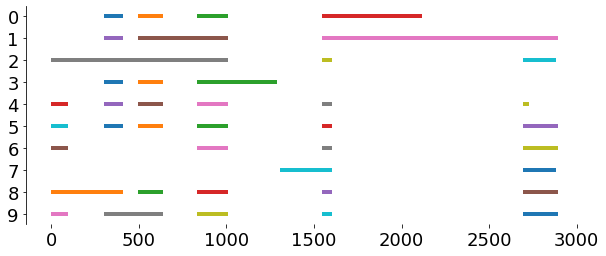

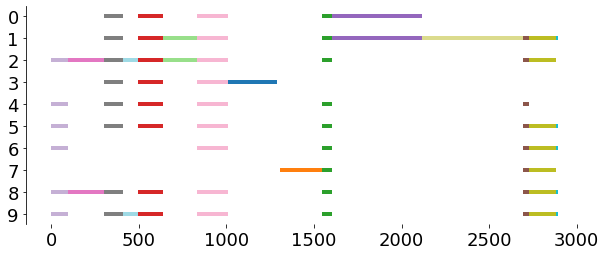

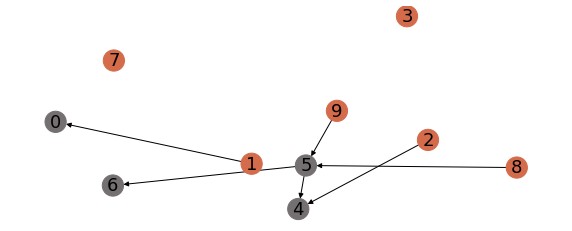

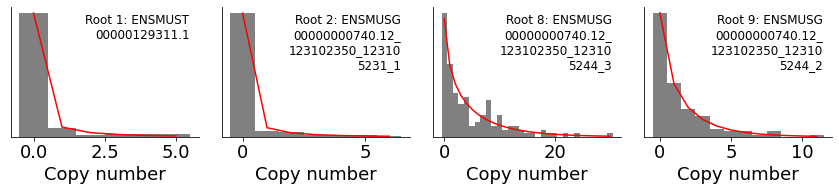

In [ ]:
data_X, meta, PARAMS, nr, roots_total, n_var, rej_stats = get_roots_fit_nb(df_gene,db,plot=True)

In [ ]:
!zip  figures.zip *.png

updating: dagfig.png (deflated 26%)
updating: exons.png (deflated 41%)
updating: margfig.png (deflated 19%)
updating: tifig.png (deflated 41%)
updating: corrcoef_2.png (deflated 9%)
updating: corrcoef_err.png (deflated 13%)
updating: corrcoef_intergene_2.png (deflated 6%)
updating: corrcoef_intergene_err.png (deflated 8%)
updating: corrcoef_intergene_hist.png (deflated 29%)
updating: corrcoef_intergene.png (deflated 6%)
updating: corrcoef_intragene_hist.png (deflated 30%)
updating: corrcoef.png (deflated 9%)
updating: corrheatmap.png (deflated 5%)
updating: corrheatmap_theo.png (deflated 7%)
updating: frac_of_tot_expr.png (deflated 26%)
updating: intragene_rej_fits.png (deflated 30%)
updating: intron_hist.png (deflated 27%)
updating: isoform_hist.png (deflated 29%)


Iterate over the 500 highest-expressed genes, identify elementary intervals, construct DAGs, and identify the roots of these DAGs (transcripts that must be derived directly from the unobserved source transcript). Then, fit negative binomial laws to their marginal distributions. Finally, compute empirical and theoretical transcript-transcript correlations.

In [ ]:
%%capture
CORR_TRUE = []
CORR_TRUE_LOW = []
CORR_TRUE_HIGH = []
CORR_THEO = []
rej_badfit = 0
rej_underdisp = 0
rej_sparse = 0
n_transc = 0
genes_rej = 0

n_iso = []
n_introns = []

t1 = time.time()
rej_badfit_mean = []
for gene_ind in range(n_high_exp_genes): 
    df_gene = df_a[df_a['gene_name']==high_exp_genes[gene_ind]]
    data_X, meta, PARAMS, nr, roots_total, n_var, rej_stats = get_roots_fit_nb(df_gene,db,plot=False)

    # rej_underdisp,rej_sparse,rej_badfit,rej_badfit_mean = rej_stats
    rej_underdisp += rej_stats[0]
    rej_sparse += rej_stats[1]
    rej_badfit += rej_stats[2]
    rej_badfit_mean.extend(rej_stats[3])

    n_iso.append(n_var[0])
    n_introns.append(n_var[1])

    CORR = np.zeros((nr,nr))
    for i in range(nr):
        for j in range(i,nr):
            g1 = PARAMS[i,1]
            g2 = PARAMS[j,1]
            b1 = PARAMS[i,0]
            b2 = PARAMS[j,0]
            CORR[i,j] = 2*np.sqrt(g1*g2)/(g1+g2)*np.sqrt(1/((1+1/b1)*(1+1/b2)))
            if i==j:
                CORR[i,j]=1
    n_transc += nr

    corr_true = np.corrcoef(data_X)
    triu = np.triu_indices(nr,k=1)

    if nr>1:
        CORR_TRUE.append(corr_true[triu][:])
        CORR_THEO.append(CORR[triu][:])

        boot = boots(data_X,1000)
        CORR_TRUE_LOW.append(np.quantile(boot,0.05,1))
        CORR_TRUE_HIGH.append(np.quantile(boot,0.95,1))

t2 = time.time()

In [ ]:
CORR_THEO = np.asarray([item for sublist in CORR_THEO for item in sublist],dtype=float)
CORR_TRUE = np.asarray([item for sublist in CORR_TRUE for item in sublist],dtype=float)
CORR_TRUE_LOW = np.asarray([item for sublist in CORR_TRUE_LOW for item in sublist],dtype=float)
CORR_TRUE_HIGH = np.asarray([item for sublist in CORR_TRUE_HIGH for item in sublist],dtype=float)

Count genes and transcripts whose fits failed to converge: mostly ones with very low expression.

In [ ]:
rej_badfit_mean = np.asarray(rej_badfit_mean)

In [ ]:
np.sum(rej_badfit_mean>1)

0

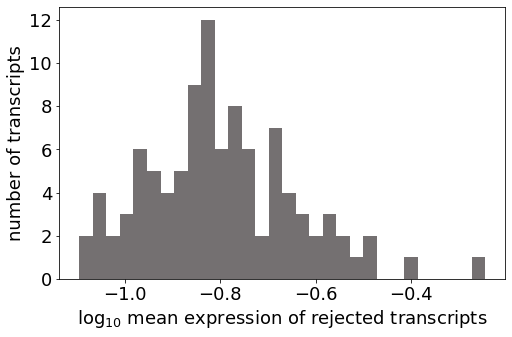

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(np.log10(rej_badfit_mean),30,color=col_gray)
plt.xlabel(r"log$_{10}$ mean expression of rejected transcripts")
plt.ylabel('number of transcripts')
plt.savefig('intragene_rej_fits.png',dpi=450)


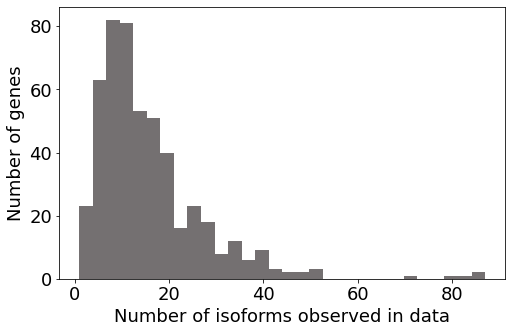

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(n_iso,30,color=col_gray)
plt.xlabel('Number of isoforms observed in data')
plt.ylabel('Number of genes')
plt.savefig('isoform_hist.png',dpi=450)


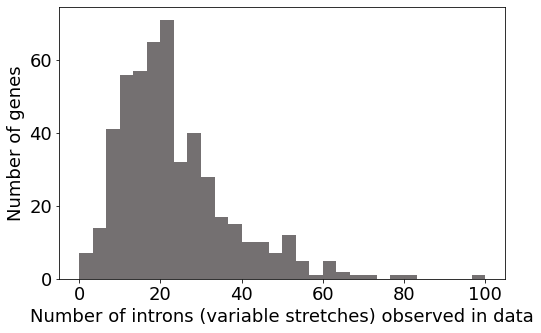

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(n_introns,30,color=col_gray)
plt.xlabel('Number of introns (variable stretches) observed in data')
plt.ylabel('Number of genes')
plt.savefig('intron_hist.png',dpi=450)

Quantify correlations that have been discarded.

In [ ]:
n_transc

1978

In [ ]:
rej_badfit 

100

In [ ]:
rej_underdisp

302

In [ ]:
rej_sparse

542

Quantify how many correlations accord and fail to accord with theoretical limits.

In [ ]:
ncorr = len(CORR_THEO)
print(ncorr)

4885


In [ ]:
corr_lower_than_hyp=np.sum(CORR_THEO > CORR_TRUE)
print(corr_lower_than_hyp)


4606


In [ ]:
corr_consistent = np.sum((CORR_THEO > CORR_TRUE) & (CORR_TRUE>0))
print(corr_consistent)

3856


In [ ]:
corr_consistent/ncorr

0.7893551688843398

In [ ]:
corr_inconsistent = np.sum(CORR_THEO < CORR_TRUE)
print(corr_inconsistent)

279


In [ ]:
corr_neg = np.sum(CORR_TRUE < 0)
print(corr_neg)

750


In [ ]:
corr_neg/ncorr

0.1535312180143296

Plot the correlations.

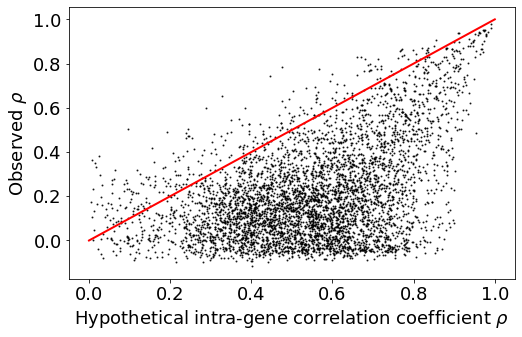

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(CORR_THEO,CORR_TRUE,'k.',alpha=0.8,markersize=2)
plt.plot([0,1],[0,1],'r-',linewidth=2)
plt.box('off')
plt.ylabel(r"Observed $\rho$")
plt.xlabel(r"Hypothetical intra-gene correlation coefficient $\rho$")
plt.savefig('corrcoef.png',dpi=450)

We can attempt to visualize the bootstrap estimates for the observed correlations.

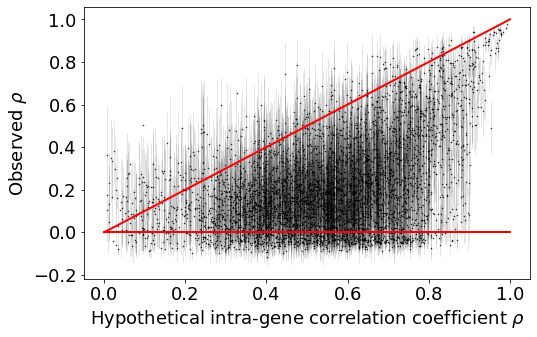

In [ ]:
boot_corr_center = (CORR_TRUE_LOW + CORR_TRUE_HIGH)/2
boot_corr_d = CORR_TRUE_HIGH-boot_corr_center

plt.figure(figsize=(8,5))

plt.errorbar(CORR_THEO,boot_corr_center,yerr = boot_corr_d,linestyle='None',color = 'k',alpha=0.1,linewidth=1)
plt.plot(CORR_THEO,CORR_TRUE,'k.',alpha=0.9,markersize=1)
plt.plot([0,1],[0,1],'r-',linewidth=2)
plt.plot([0,1],[0,0],'r-',linewidth=2)

plt.box('off')
plt.ylabel(r"Observed $\rho$")
plt.xlabel(r"Hypothetical intra-gene correlation coefficient $\rho$")
plt.savefig('corrcoef_2.png',dpi=450)

In [ ]:
ub_below_zero = sum(CORR_TRUE_HIGH<0)
print(ub_below_zero)

144


In [ ]:
ub_below_zero/ncorr

0.02947799385875128

In [ ]:
lb_above_theo = sum(CORR_TRUE_LOW>CORR_THEO)
print(lb_above_theo)

29


In [ ]:
lb_above_theo/ncorr

0.00593654042988741

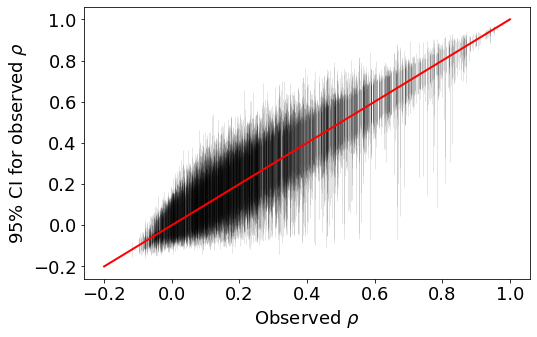

In [ ]:
plt.figure(figsize=(8,5))
plt.errorbar(CORR_TRUE,boot_corr_center,yerr = boot_corr_d,linestyle='None',color = 'k',alpha=0.1,linewidth=1)

plt.plot([-0.2,1],[-0.2,1],'r-',linewidth=2)
plt.xlabel(r"Observed $\rho$")
plt.ylabel(r"95% CI for observed $\rho$")
plt.savefig('corrcoef_err.png',dpi=450)

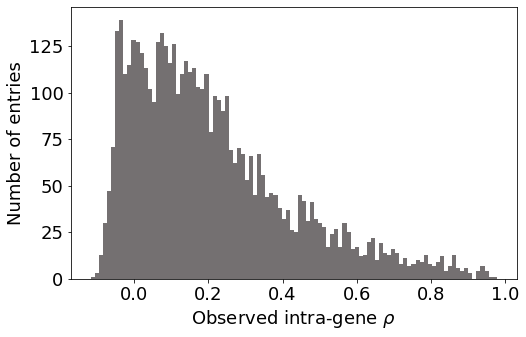

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(CORR_TRUE,100,color=col_gray)
plt.xlabel(r"Observed intra-gene $\rho$")
plt.ylabel('Number of entries')
plt.savefig('corrcoef_intragene_hist.png',dpi=450)

In [ ]:
print(t2-t1)

115.2541298866272


We can apply the same model to inter-gene interactions.

In [ ]:
%%capture
CORR_TRUE = []
CORR_THEO = []
rej_badfit = 0
rej_underdisp = 0
rej_construction = 0
rej_sparse = 0
n_transc = 0
genes_rej = 0
df_high_exp = pd.DataFrame(columns = df_a.columns)

ngen = n_high_exp_genes
# ngen = 50
params_storage = np.zeros((ngen,2))
# data_highest_exp_roots = 

frac_of_total_root_expr = []

t1 = time.time()
rej_badfit_mean = []
for gene_ind in range(ngen):     
    df_gene = df_a[df_a['gene_name']==high_exp_genes[gene_ind]]
    data_X, meta, PARAMS, nr, roots_total, n_var, rej_stats = get_roots_fit_nb(df_gene,db,plot=False)

    fit_roots_total = data_X.sum(1)

    try:
        HIGHEST_IND = np.argmax(fit_roots_total)
        frac_of_total_root_expr.append(fit_roots_total[HIGHEST_IND]/roots_total)

        meta = meta[HIGHEST_IND]
        data_X = data_X[HIGHEST_IND]
        PARAMS = PARAMS[HIGHEST_IND]
    except: #if all of the roots are unusable because they are sparse or insufficiently NB-like
        meta = ['not a gene','not a gene','not a gene']
        print(gene_ind)
        data_X = [np.nan]*137
        PARAMS = [np.nan]*2

    df_row = []
    df_row.extend(meta)
    df_row.extend(data_X)

    df_high_exp.loc[gene_ind] = df_row
    params_storage[gene_ind,:] = PARAMS


t2 = time.time()

In [ ]:
FILT = df_high_exp['transcript_id']!='not a gene'

In [ ]:
params_storage = params_storage[FILT]

In [ ]:
df_high_exp = df_high_exp[FILT]

In [ ]:
df_high_exp

,transcript_id,gene_id,gene_name,ATTTCTGCAAGCTGAG,TTGTAGGTCAGTGTTG,TGGCGCAGTACGCACC,TCAGGATTCACCCGAG,ACCGTAACAAGCGTAG,TGGACGCAGAACTGTA,TGGTTCCAGGTGTGGT,TCGTACCTCCTTGCCA,AAGCCGCGTGTGAATA,CCTCAGTCATCGACGC,CAAGAAACATATACCG,GACTAACTCCAAAGTC,GATCGCGCATCCCACT,GAACGGAGTCGCATCG,GGTGCGTAGAACAACT,CAGCTGGGTGCCTGGT,GACACGCGTATCTGCA,GTGTGCGCATTGTGCA,CCTTACGTCACGCATA,TCTCTAACAATGAAAC,CTGTGCTTCCGATATG,GATGAGGAGAACAACT,CGGACTGCAAGAAGAG,ATCCGAATCTGGCGAC,CAAGGCCCAAGCGTAG,CTCGTACGTACTTGAC,GTACGTATCTTCATGT,GAGTCCGCATTGGTAC,CGCCAAGCATCCGCGA,CGTGAGCCACATTCGA,GTAACTGAGATGAGAG,GGATGTTAGGTTACCT,TCGCGAGGTCTAGAGG,CGGACTGAGTTGAGTA,CTAATGGGTCGCATCG,GCACATAAGCAGACTG,CTTGGCTCATTGAGCT,...,CGATGTACACCATGTA,TCTGGAAGTATAGGGC,ACAGCCGTCTTGAGAC,AGCGGTCGTTCCAACA,CCGTACTCAATCGGTT,CCGTACTAGTAGGCCA,CGGACACGTCTCAACA,ACGTCAAGTATGCTTG,TCAGGATAGTACCGGA,TGATTTCCACGGTAAG,GGACAGACACAGCCCA,CCAATCCAGTCATGCT,ATCATCTTCCGTAGGC,CACCACTCAGTAGAGC,CACCTTGTCTGCAGTA,AGCGGTCGTTATCACG,ACACCGGAGGAGTACC,AGCGTATTCTATCCTA,GCGAGAAAGAGCTTCT,GACGTGCTCGTCGTTC,TTATGCTCACGTCAGC,TCAGGATAGAAGGTTT,TGATTTCAGATGTGTA,GGGTTGCAGATGCCAG,AGAATAGAGGAGTACC,GGGCACTTCTGTTGAG,TTAGGACGTATAGGTA,CGGAGTCCACAGGAGT,CTGATCCCAGATTGCT,CTCGGGACATCACAAC,TCTATTGGTGATGATA,TCACAAGAGTTTAGGA,CAGCATAAGACGACGT,CATCGAACACATGACT,CGTCTACAGAGTGAGA,TGCCCTACACCCAGTG,TAGTTGGGTTCAACCA,TAGGCATGTCTCCATC,ACTGATGTCCAACCAA,GTAGGCCTCTCGCATC
0,ENSMUST00000114050.7,ENSMUSG00000079523.8,Tmsb10,1623.0,1167.0,1128.0,1545.0,1498.0,2282.0,1502.0,1880.0,1297.0,1535.0,1022.0,781.0,1818.0,1068.0,1221.0,451.0,914.0,1541.0,511.0,1997.0,720.0,1249.0,1406.0,645.0,1423.0,1842.0,912.0,551.0,1008.0,289.0,1426.0,613.0,1695.0,1202.0,1185.0,642.0,952.0,...,43.0,84.0,32.0,62.0,56.0,191.0,28.0,43.0,78.0,39.0,12.0,39.0,8.0,51.0,154.0,31.0,22.0,4.0,7.0,17.0,17.0,28.0,42.0,3.0,12.0,10.0,18.0,64.0,17.0,8.0,45.0,13.0,14.0,56.0,13.0,12.0,34.0,26.0,5.0,4.0
1,ENSMUST00000086519.11,ENSMUSG00000067274.10,Rplp0,1762.0,1359.0,1124.0,1595.0,1474.0,1503.0,1622.0,1343.0,1479.0,1781.0,957.0,1051.0,1637.0,1377.0,853.0,715.0,1057.0,1246.0,1169.0,1772.0,867.0,925.0,1393.0,961.0,1126.0,901.0,1056.0,552.0,839.0,771.0,1259.0,915.0,913.0,758.0,922.0,935.0,971.0,...,91.0,148.0,25.0,79.0,40.0,146.0,45.0,36.0,113.0,70.0,25.0,32.0,22.0,66.0,177.0,60.0,25.0,6.0,11.0,17.0,31.0,27.0,45.0,11.0,10.0,9.0,19.0,70.0,30.0,33.0,46.0,7.0,7.0,54.0,23.0,3.0,34.0,26.0,14.0,17.0
2,ENSMUST00000089377.5,ENSMUSG00000068220.6,Lgals1,1171.0,1179.0,863.0,1082.0,825.0,1132.0,974.0,639.0,799.0,910.0,743.0,837.0,905.0,744.0,661.0,442.0,797.0,886.0,360.0,1178.0,687.0,636.0,561.0,701.0,802.0,639.0,783.0,378.0,432.0,359.0,728.0,657.0,669.0,879.0,585.0,467.0,627.0,...,18.0,48.0,41.0,48.0,28.0,74.0,41.0,8.0,58.0,25.0,11.0,11.0,11.0,27.0,122.0,29.0,12.0,2.0,4.0,4.0,12.0,17.0,20.0,10.0,10.0,13.0,9.0,43.0,12.0,3.0,24.0,3.0,6.0,27.0,9.0,3.0,20.0,11.0,3.0,2.0
3,ENSMUST00000170715.7,ENSMUSG00000044533.15,Rps2,1681.0,1218.0,1009.0,1428.0,1360.0,1646.0,1634.0,1134.0,1056.0,1430.0,937.0,975.0,1302.0,1285.0,956.0,606.0,908.0,1175.0,844.0,1709.0,739.0,806.0,1426.0,813.0,870.0,811.0,860.0,473.0,719.0,655.0,945.0,881.0,728.0,1080.0,837.0,840.0,769.0,...,88.0,142.0,49.0,44.0,41.0,103.0,24.0,23.0,93.0,64.0,30.0,39.0,15.0,46.0,143.0,62.0,26.0,11.0,18.0,20.0,35.0,37.0,35.0,13.0,9.0,15.0,17.0,42.0,21.0,13.0,48.0,3.0,5.0,64.0,17.0,10.0,29.0,16.0,7.0,1.0
4,ENSMUST00000042235.14,ENSMUSG00000037742.14,Eef1a1,1185.0,1193.0,1064.0,1473.0,1131.0,1593.0,1454.0,978.0,1251.0,1105.0,958.0,966.0,989.0,1064.0,856.0,604.0,908.0,847.0,1091.0,1346.0,1089.0,906.0,1068.0,413.0,463.0,488.0,1087.0,297.0,777.0,779.0,915.0,872.0,859.0,971.0,817.0,1046.0,697.0,...,96.0,157.0,40.0,79.0,46.0,126.0,28.0,19.0,83.0,64.0,45.0,14.0,19.0,54.0,188.0,74.0,30.0,8.0,11.0,23.0,46.0,59.0,45.0,19.0,14.0,17.0,21.0,97.0,30.0,52.0,49.0,12.0,15.0,71.0,17.0,27.0,43.0,40.0,12.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
len(frac_of_total_root_expr)

490

In [ ]:
t2-t1

34.94524335861206

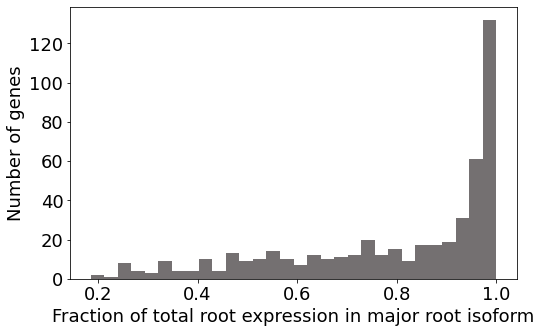

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(frac_of_total_root_expr,30,color=col_gray)
plt.xlabel(r"Fraction of total root expression in major root isoform")
plt.ylabel('Number of genes')
plt.savefig('frac_of_tot_expr.png',dpi=450)

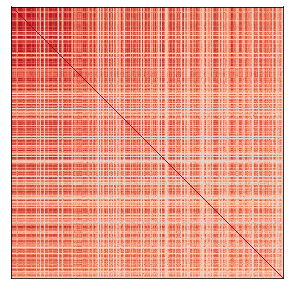

In [ ]:
corr_true = np.asarray(df_high_exp.iloc[:,3:].T.corr())
plt.figure(figsize=(5,5))
plt.imshow(corr_true, cmap='coolwarm', interpolation='nearest',vmin=-1,vmax=1)
plt.xticks([])
plt.yticks([])
plt.savefig('corrheatmap.png',dpi=450)

In [ ]:
boot = boots(np.asarray(df_high_exp.iloc[:,3:]),1000)
CORR_TRUE_LOW = np.quantile(boot,0.05,1)
CORR_TRUE_HIGH = np.quantile(boot,0.95,1)

In [ ]:
%%capture

# ngen = n_high_exp_genes
ngen = len(corr_true)
corr_theo = np.zeros((ngen,ngen))
t1 = time.time()
for i in range(ngen): 
    for j in range(ngen):
        if i==j:
            corr_theo[i,j]=1
        else:
            b1,g1 = params_storage[i,:]
            b2,g2 = params_storage[j,:]
            corr_theo[i,j] = 2*np.sqrt(g1*g2)/(g1+g2)*np.sqrt(1/((1+1/b1)*(1+1/b2)))
t2 = time.time()

In [ ]:
t2-t1

2.1157009601593018

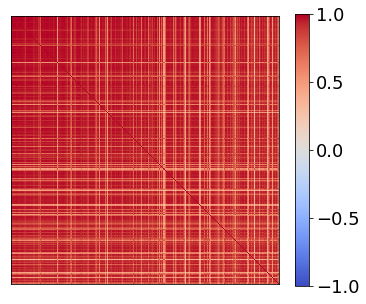

In [ ]:
plt.figure(figsize=(6,5))
plt.imshow(corr_theo, cmap='coolwarm', interpolation='nearest',vmin=-1,vmax=1)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.savefig('corrheatmap_theo.png',dpi=450)

In [ ]:
ngen

490

In [ ]:
triu = np.triu_indices(ngen,k=1)
CORR_THEO = corr_theo[triu]
CORR_TRUE = corr_true[triu]

In [ ]:
ncorr = len(CORR_THEO)
print(ncorr)

119805


In [ ]:
corr_lower_than_hyp = np.sum(CORR_THEO > CORR_TRUE)
print(corr_lower_than_hyp)

119503


In [ ]:
corr_lower_than_hyp/ncorr

0.9974792370936104

In [ ]:
corr_inconsistent = np.sum(CORR_THEO < CORR_TRUE)
print(corr_inconsistent)

302


In [ ]:
corr_consistent = np.sum((CORR_THEO > CORR_TRUE) & (CORR_TRUE>0))
print(corr_consistent)

117542


In [ ]:
corr_neg = np.sum(CORR_TRUE<0)
print(corr_neg)

1961


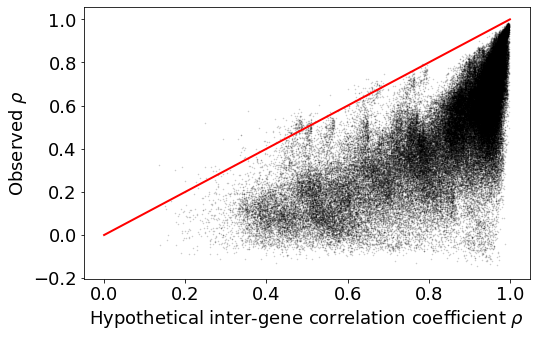

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(CORR_THEO,CORR_TRUE,'k.',alpha=0.2,markersize=1)
plt.plot([0,1],[0,1],'r-',linewidth=2)
plt.box('off')
plt.ylabel(r"Observed $\rho$")
plt.xlabel(r"Hypothetical inter-gene correlation coefficient $\rho$")
plt.savefig('corrcoef_intergene.png',dpi=450)

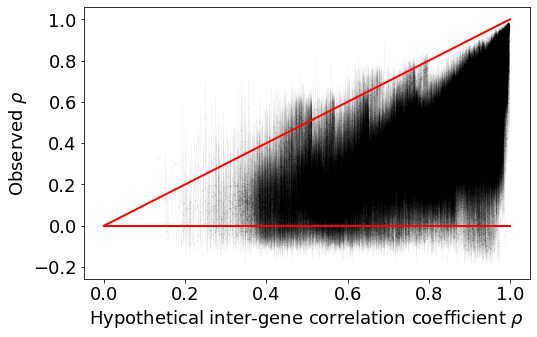

In [ ]:
boot_corr_center = (CORR_TRUE_LOW + CORR_TRUE_HIGH)/2
boot_corr_d = CORR_TRUE_HIGH-boot_corr_center

plt.figure(figsize=(8,5))

plt.errorbar(CORR_THEO,boot_corr_center,yerr = boot_corr_d,linestyle='None',color = 'k',alpha=0.05,linewidth=0.6)
plt.plot(CORR_THEO,CORR_TRUE,'k.',alpha=0.2,markersize=0.5)
plt.plot([0,1],[0,1],'r-',linewidth=2)
plt.plot([0,1],[0,0],'r-',linewidth=2)

plt.box('off')
plt.ylabel(r"Observed $\rho$")
plt.xlabel(r"Hypothetical inter-gene correlation coefficient $\rho$")
plt.savefig('corrcoef_intergene_2.png',dpi=450)

In [ ]:
ub_below_zero = sum(CORR_TRUE_HIGH<0)
print(ub_below_zero)

262


In [ ]:
ub_below_zero/ncorr

0.0021868870247485498

In [ ]:
lb_above_theo = sum(CORR_TRUE_LOW>CORR_THEO)
print(lb_above_theo)

5


In [ ]:
lb_above_theo/ncorr

4.1734485205125e-05

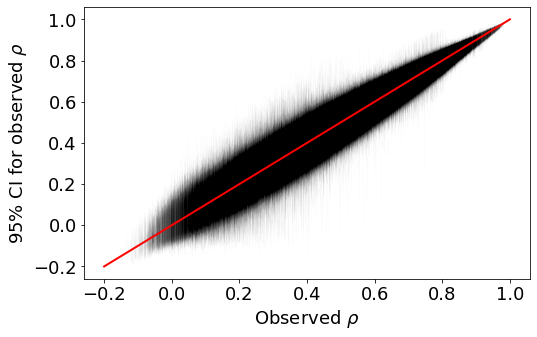

In [ ]:
plt.figure(figsize=(8,5))
plt.errorbar(CORR_TRUE,boot_corr_center,yerr = boot_corr_d,linestyle='None',color = 'k',alpha=0.02,linewidth=0.5)

plt.plot([-0.2,1],[-0.2,1],'r-',linewidth=2)
plt.xlabel(r"Observed $\rho$")
plt.ylabel(r"95% CI for observed $\rho$")
plt.savefig('corrcoef_intergene_err.png',dpi=450)

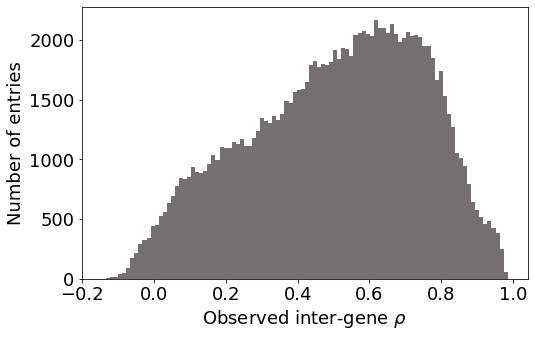

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(corr_true[triu],100,color=col_gray)
plt.xlabel(r"Observed inter-gene $\rho$")
plt.ylabel('Number of entries')
plt.savefig('corrcoef_intergene_hist.png',dpi=450)

In [ ]:
!zip  figures.zip *.png

updating: dagfig.png (deflated 26%)
updating: exons.png (deflated 41%)
updating: margfig.png (deflated 19%)
updating: tifig.png (deflated 41%)
updating: corrcoef_2.png (deflated 8%)
updating: corrcoef_err.png (deflated 13%)
updating: corrcoef_intergene_2.png (deflated 7%)
updating: corrcoef_intergene_err.png (deflated 8%)
updating: corrcoef_intergene_hist.png (deflated 29%)
updating: corrcoef_intergene.png (deflated 6%)
updating: corrcoef_intragene_hist.png (deflated 30%)
updating: corrcoef.png (deflated 9%)
updating: corrheatmap.png (deflated 5%)
updating: corrheatmap_theo.png (deflated 7%)
updating: frac_of_tot_expr.png (deflated 26%)
updating: intragene_rej_fits.png (deflated 30%)
updating: intron_hist.png (deflated 27%)
updating: isoform_hist.png (deflated 29%)
